In [1]:
from voc_dataset import VOCDetection
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os
from lib.utils import detection_collate 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
import cv2
from lib.utils import nms
from lib.augmentations import preproc_for_test
import matplotlib.pyplot as plt
from lib.utils import detect
from voc_dataset import VOC_LABELS


%matplotlib inline



In [2]:
VOC_CLASSES = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

### load model

In [3]:
model = SSD(opt.num_classes, opt.anchor_num)
state_dict = torch.load('weights/loss-2079.08.pth', map_location='cpu')
model.load_state_dict(state_dict)

### anchors

In [4]:
multibox_encoder = MultiBoxEncoder(opt)

### load and preprocess image

In [5]:
image = 'images/000017.jpg'
src = cv2.imread(image, cv2.IMREAD_COLOR)
image = preproc_for_test(src, opt.min_size, opt.mean)
image = torch.from_numpy(image)

### predict

In [6]:
with torch.no_grad():
    loc, conf = model(image.unsqueeze(0))

### convert torch ----> numpy

In [7]:
loc = loc[0]
conf = conf[0]
conf = F.softmax(conf, dim=1)
conf = conf.numpy()
loc = loc.numpy()

### decode location

In [8]:
decode_loc = multibox_encoder.decode(loc)

### detect

In [9]:
gt_boxes, gt_confs, gt_labels = detect(decode_loc, conf, nms_threshold=0.45, gt_threshold=0.1)

### map locations back to original image

In [10]:
h, w = src.shape[:2]
gt_boxes[:, 0] = gt_boxes[:, 0] * w
gt_boxes[:, 1] = gt_boxes[:, 1] * h
gt_boxes[:, 2] = gt_boxes[:, 2] * w
gt_boxes[:, 3] = gt_boxes[:, 3] * h
gt_boxes = gt_boxes.astype(int)

### show

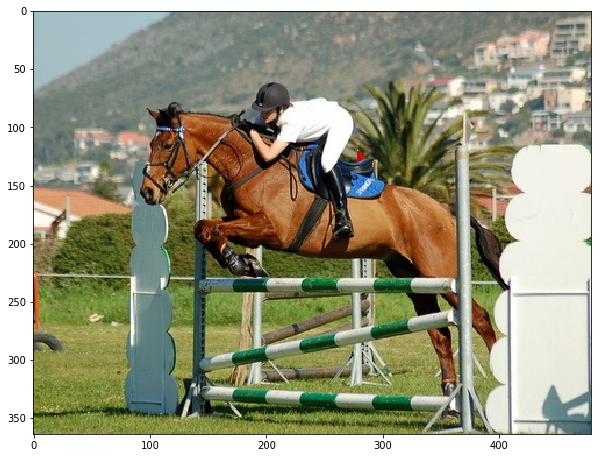

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(src[:, :, ::-1])

6 0.10389118 440 79 482 107
9 0.17412587 97 96 432 348
12 0.7700145 94 81 405 344
12 0.36244088 121 69 342 217
12 0.2791557 86 74 206 200
12 0.16799688 127 104 257 228
12 0.16639665 78 97 184 330
12 0.10963585 106 153 227 278
12 0.10450739 311 140 427 264
14 0.529446 132 63 319 201
14 0.35557207 69 66 417 353
14 0.21045592 160 57 231 177
14 0.20240606 198 55 276 178
14 0.1502315 415 79 447 116
14 0.13314188 217 59 364 174
14 0.13278212 176 59 219 120
14 0.13232026 68 194 118 345
14 0.12279546 88 195 140 342
14 0.12011025 423 70 455 109
14 0.106965214 159 60 270 123


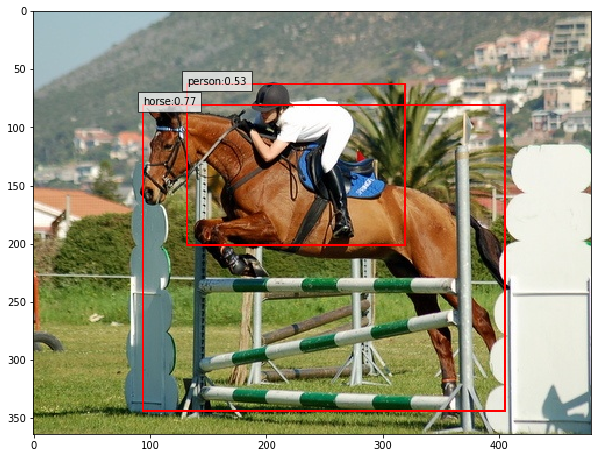

In [12]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(src[:, :, ::-1])
for box, label, score in zip(gt_boxes, gt_labels, gt_confs):
        print(label, score, *box)
        if score > 0.4:
            text = '{:s}:{:.2f}'.format(VOC_LABELS[label], score)
            ax.add_patch(
                plt.Rectangle(
                (box[0], box[1]), 
                 box[2] - box[0], 
                 box[3] - box[1],
                 fill=False, 
                 edgecolor='red',
                 linewidth=2)
            )
            ax.text(box[0], box[1], text,
                    bbox={'facecolor' : 'white', 'alpha' : 0.7, 'pad' : 5}
                   )
plt.savefig('images/1.jpg')